# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter
import pickle
from mpl_toolkits.basemap import Basemap, cm
import matplotlib
import cmocean

warnings.filterwarnings('ignore')

%matplotlib notebook

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [4]:
GA01 = pd.read_csv('/ocean/brogalla/GEOTRACES/data/GEOTRACES_IDP2017_v2_GA01_Pb.csv')

In [5]:
lon_GA01 = np.array(GA01['Longitude [degrees_east]'])
lat_GA01 = np.array(GA01['Latitude [degrees_north]'])
dep_GA01 = np.array(GA01['DEPTH [m]'])
dPb_GA01 = np.array(GA01['Pb_D_CONC_BOTTLE [pmol/kg]'])

In [6]:
ddPb_GA01 = np.array([dPb_GA01[i+1]-dPb_GA01[i] for i in range(0,len(dPb_GA01)-1)])

# bottom of cast index:
ind       = [19, 39, 59, 81, 102, 123, 145, 189, 211, 233, 255, 264, 282, 293, \
             315, 337, 359, 380, 403, 414, 436, 455, 475] 
for i in ind:
    ddPb_GA01[i-1] = np.nan

In [7]:
POC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/b.e11.B1850C5CN.f09_g16.005.pop.h.POC_FLUX_IN.200001-209912.nc')
POC_lon  = np.array(POC.variables['TLONG'])
POC_lat  = np.array(POC.variables['TLAT'])
POC_dep  = np.array(POC.variables['z_t'])*1e-2    # depth from surface (cm)
POC_time = np.array(POC.variables['time'])        # days since 0000-01-01 00:00:00, noleap
POC_flux = np.array(POC.variables['POC_FLUX_IN']) # mmol /m3 cm/s

##### Functions:

In [8]:
def assoc_depth(depth_obs):
    
    # find depths that are in common
    common_depths = np.empty_like(depth_obs)
    index_depths  = np.empty_like(depth_obs)
    
    i=0
    for depth in depth_obs:
        min_val  = np.argmin(np.abs(POC_dep - depth))
        if np.abs(POC_dep[min_val] - depth) > 100:
            common_depths[i] = np.nan
            index_depths[i]  = np.nan
        else:
            common_depths[i] = POC_dep[min_val]
            index_depths[i]  = min_val
        i+=1
        
    return common_depths, index_depths

##### Calculations:

In [9]:
# Find corresponding lons at lats for POC flux compared to the station locations:

i_stn = [];  j_stn = [];
for stn in range(0,len(lon_GA01)):
    i, j   = ar.find_closest_model_point(lon_GA01[stn], lat_GA01[stn], POC_lon, POC_lat, \
                                       tols={'NEMO': {'tol_lon': 0.5, 'tol_lat': 0.5}})
    
    i_stn.append(i);   j_stn.append(j);
    
i_POC  = np.array(i_stn);  j_POC  = np.array(j_stn);

In [10]:
POC_common_depths, POC_z_index = assoc_depth(dep_GA01)

In [11]:
POC_array = []; POC2_array = [];

for ind in range(0,len(dep_GA01)):
    try:
        POC_flx = POC_flux[191, int(POC_z_index[ind]), i_POC[ind], j_POC[ind]]
    except:
        POC_flx = np.nan
        
    POC_array.append(POC_flx)
    
POC_flux_stns = np.array(POC_array)

POC_flux_stns[POC_flux_stns > 1e10] = np.nan
POC_flux_stns[POC_flux_stns == 0.0] = np.nan

In [12]:
# Mask places where depths are too different:
dPb_masked  = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(dPb_GA01)), dPb_GA01)
ddPb_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns[:-1]), np.isnan(ddPb_GA01)), ddPb_GA01)
POC_masked  = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(dPb_GA01)), POC_flux_stns)
dPOC_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns[:-1]), np.isnan(ddPb_GA01)), POC_flux_stns[:-1])

<IPython.core.display.Javascript object>


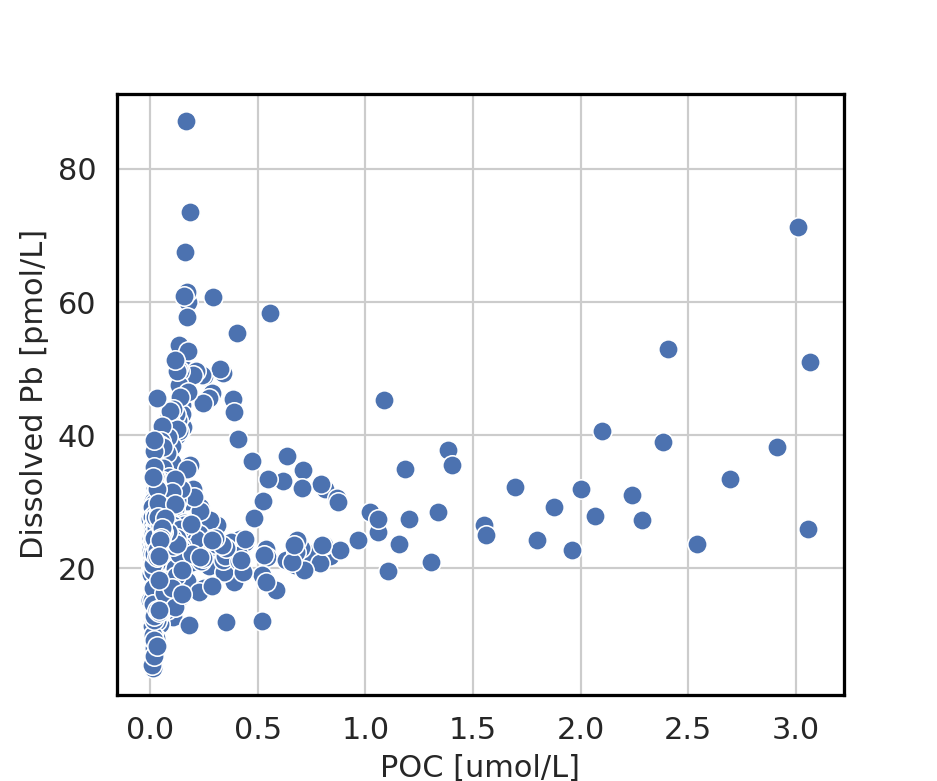

In [65]:
st = sns.axes_style("whitegrid")

with st:    
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    sns.scatterplot(POC_masked*1e3, dPb_masked, s=80)
    
    ax.set_ylabel('Dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('POC flux [umol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

<IPython.core.display.Javascript object>


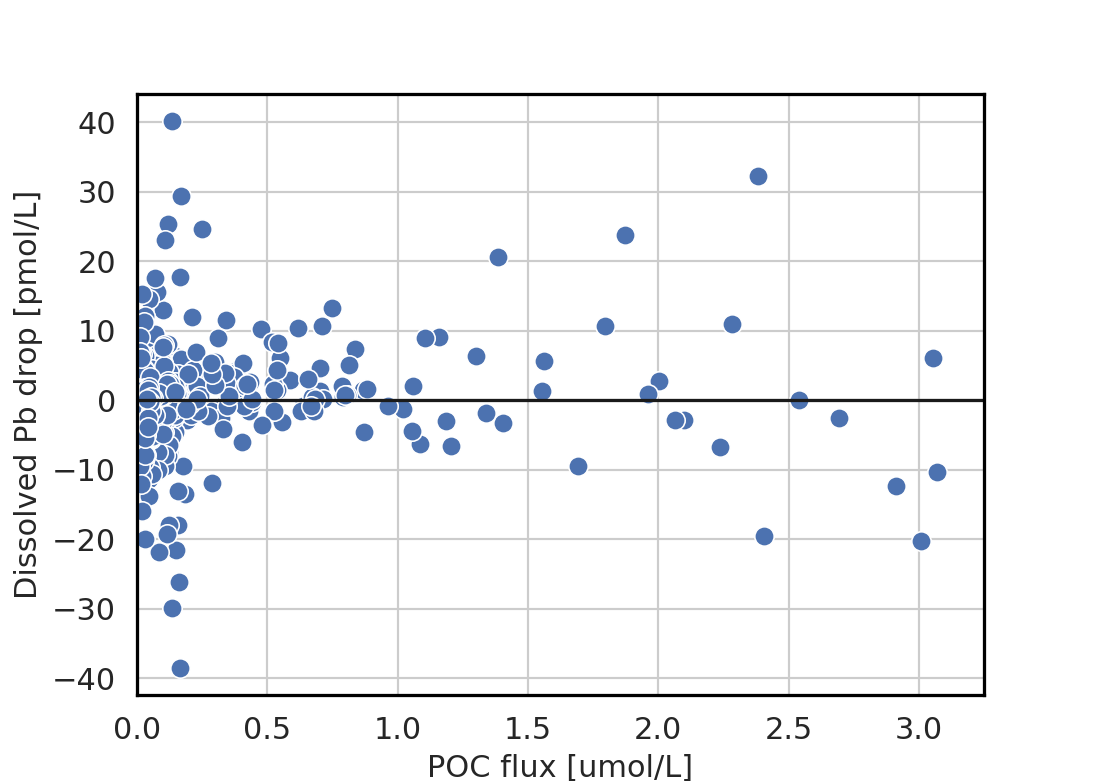

In [15]:
st = sns.axes_style("whitegrid")

with st:    
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_xlim(0,3.25)
    
    sns.lineplot([0,3.25], [0,0], c='k')
    sns.scatterplot(dPOC_masked*1e3, ddPb_masked, s=80)
    
    ax.set_ylabel('Dissolved Pb drop [pmol/L]', fontsize=14)
    ax.set_xlabel('POC flux [umol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

In [66]:
def calc_drop_in_chunks(stn_name):
    
    # indices of station
    POC_indices = np.argwhere(POC_names==stn_name)
    Pb_indices  = np.argwhere(obs_names==stn_name)
    
    # Data at that station:
    POC = POC_observ[POC_indices]
    Pb  = obs_dPb[Pb_indices]
    POC_depth = POC_depths[POC_indices]
    Pb_depth  = obs_depths[Pb_indices]
    
    # Estimate the drop over chunks of depth:
    chunk      = 30
    num_chunks = np.int(np.floor(np.divide(np.min([np.max(Pb_depth), np.max(POC_depth)]),chunk)))
    
    Pb_drop_ch = []; POC_ch = [];
    for i in range(1,num_chunks):
        Pb_drop_chunk = np.ma.mean(Pb[(Pb_depth > chunk*(int(i-1))) & (Pb_depth < chunk*int(i))]) - \
                        np.ma.mean(Pb[(Pb_depth > chunk*int(i))     & (Pb_depth < chunk*(int(i+1)))])
        POC_chunk     = np.ma.mean(POC[(POC_depth > chunk*int(i))   & (POC_depth < chunk*(int(i+1)))])
        
        Pb_drop_ch.append(Pb_drop_chunk)
        POC_ch.append(POC_chunk)

    Pb_drops  = np.array(Pb_drop_ch)
    POC_means = np.array(POC_ch)
    return Pb_drops, POC_means

In [67]:
Pb_drops  = []
POC_means = []
lst_names = []

for stn in stn_names[1:]:
    try:
        Pb_drops_stn, POC_means_stn = calc_drop_in_chunks(stn)
        Pb_drops.append(Pb_drops_stn)
        POC_means.append(POC_means_stn)
        lst_names.append([stn for i in Pb_drops_stn]) # list of names
    except:
        print("Data not available for station: ", stn)

Pb_drop    = np.concatenate(Pb_drops).ravel()
POC_mean   = np.concatenate(POC_means).ravel()
list_names = np.concatenate(lst_names).ravel()

Data not available for station:  CAA2
Data not available for station:  CAA9


In [68]:
POC_mean_masked = np.ma.masked_where(np.logical_or(np.isnan(Pb_drop), np.isnan(POC_mean)), POC_mean)
Pb_drop_masked  = np.ma.masked_where(np.logical_or(np.isnan(Pb_drop), np.isnan(POC_mean)), Pb_drop)
names_masked    = np.ma.masked_where(np.logical_or(np.isnan(Pb_drop), np.isnan(POC_mean)), list_names)

print('Number of non-NaN elements in POC mean: ', np.count_nonzero(~np.isnan(POC_mean)))
print('Number of non-NaN elements in Pb drop:  ',np.count_nonzero(~np.isnan(Pb_drop)))

Number of non-NaN elements in POC mean:  69
Number of non-NaN elements in Pb drop:   42


<IPython.core.display.Javascript object>


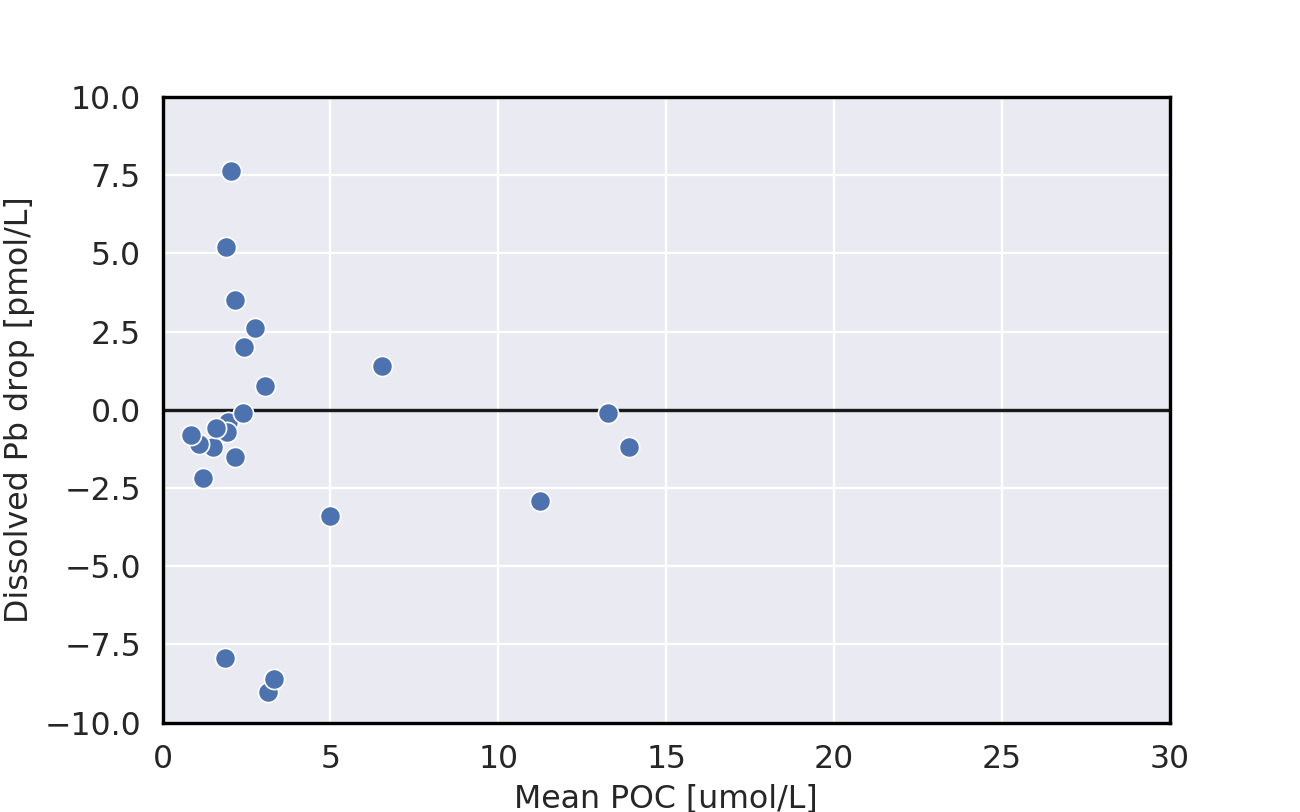

In [69]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
st = sns.axes_style("whitegrid")

with st:
    ax.set(xlim=(0,30.0), ylim=(-10,10))
    sns.lineplot([0, 100], [0, 0], c='k', ax=ax)
    sns.scatterplot(POC_mean_masked, Pb_drop_masked*1e3, s=80, zorder=3, ax=ax)
    
    ax.set_ylabel('Dissolved Pb drop [pmol/L]', fontsize=14)
    ax.set_xlabel('Mean POC [umol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    